# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

# Data Understanding and Prelim Prep

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import itertools
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
df = pd.read_csv('/content/drive/MyDrive/ML/vehicles.csv')

In [165]:
df.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [167]:
# What is the initial cardinality of our data?
for column in df.columns:
  print(column, ' : ', df[column].nunique())

id  :  426880
region  :  404
price  :  15655
year  :  114
manufacturer  :  42
model  :  29649
condition  :  6
cylinders  :  8
fuel  :  5
odometer  :  104870
title_status  :  6
transmission  :  3
VIN  :  118246
drive  :  3
size  :  4
type  :  13
paint_color  :  12
state  :  51


In [168]:
# The id and VIN are unlikely to be helpful because they're unique and unrelated
# There are 392 regions and not much consistency to their type.
# Some are states, some are cities and counties, etc. We'll rely on State instead.
# Drop model because cardinality too high and drastically impacts model performance if one-hot encoded
columns_to_drop = ['VIN', 'id', 'region', 'model']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [169]:
# Can we drop null values and still have sufficient data to build a model?
null_counts = df.isnull().sum()
null_counts_df = pd.DataFrame({'Column': null_counts.index, 'Null Count': null_counts.values})
null_counts_df['% of entries'] = null_counts_df['Null Count'] / len(df) * 100
null_counts_df

,Column,Null Count,% of entries
0,price,0,0.000000
1,year,1205,0.282281
2,manufacturer,17646,4.133714
3,condition,174104,40.785232
4,cylinders,177678,41.622470
5,fuel,3013,0.705819
6,odometer,4400,1.030735
7,title_status,8242,1.930753
8,transmission,2556,0.598763
9,drive,130567,30.586347


In [170]:
# drop nulls from our dataframe
df = df.dropna(subset=['size'])

In [171]:
# drop cars with a price of 0.0
# it's unlikely our used car dealership will want to give cars away for free
df = df[(df['price'] >= 500) & (df['price'] <= 80000)]

In [172]:
# drop the remaining nulls
df = df.dropna()

In [173]:
print(f'Total Number of Data Points : {len(df)}')

Total Number of Data Points : 75057


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75057 entries, 31 to 426833
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         75057 non-null  int64  
 1   year          75057 non-null  float64
 2   manufacturer  75057 non-null  object 
 3   condition     75057 non-null  object 
 4   cylinders     75057 non-null  object 
 5   fuel          75057 non-null  object 
 6   odometer      75057 non-null  float64
 7   title_status  75057 non-null  object 
 8   transmission  75057 non-null  object 
 9   drive         75057 non-null  object 
 10  size          75057 non-null  object 
 11  type          75057 non-null  object 
 12  paint_color   75057 non-null  object 
 13  state         75057 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 8.6+ MB


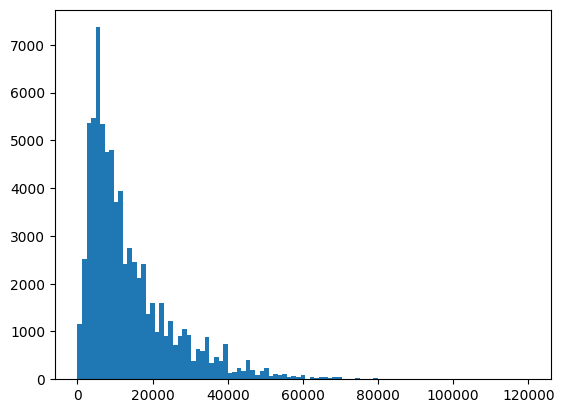

In [175]:
# Examining the target value
# Create a histogram of Car Prices
bins_edges = np.linspace(0, 120000, 100)
plt.hist(df['price'], bins=bins_edges)
plt.show()

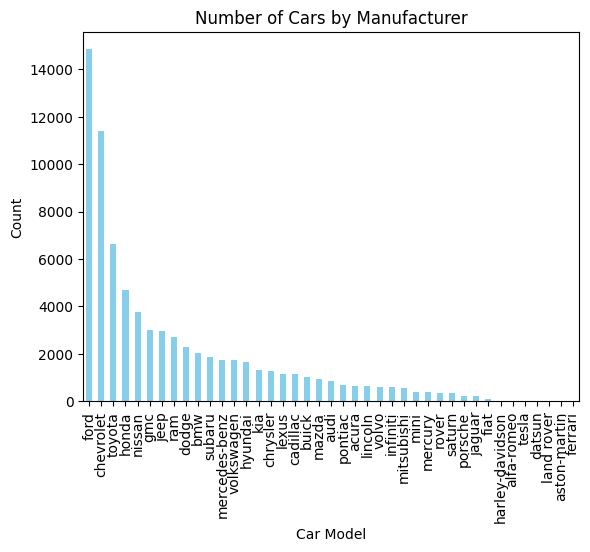

In [176]:
# Are there car manufacturers for which there are few data points?
model_counts = df['manufacturer'].value_counts()
model_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Cars by Manufacturer')
plt.xlabel('Car Model')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


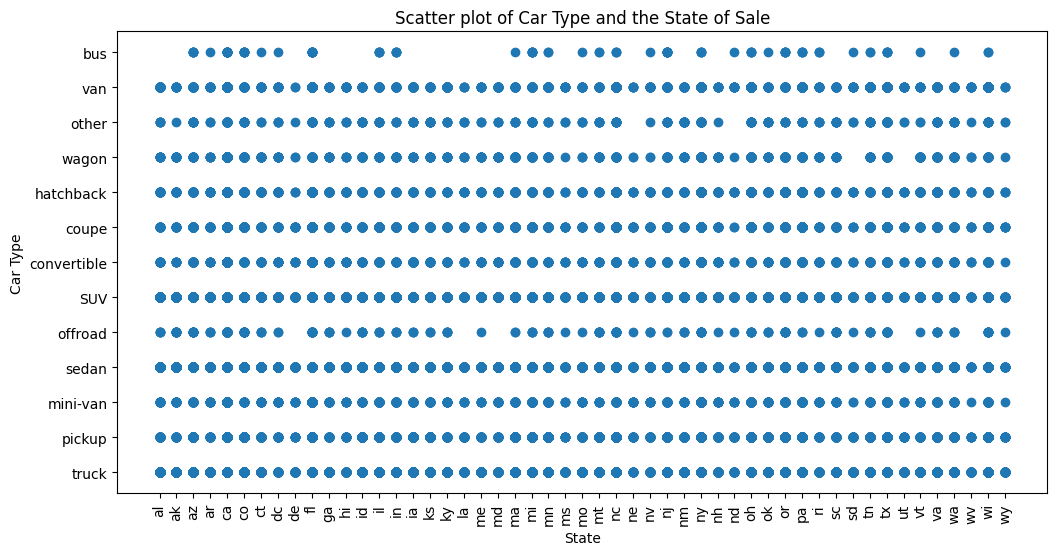

In [177]:
# Are there car types that aren't sold in certain states?
plt.figure(figsize=(12, 6))
plt.scatter(x=df['state'], y=df['type'])
plt.xlabel('State')
plt.ylabel('Car Type')
plt.title('Scatter plot of Car Type and the State of Sale')
plt.xticks(rotation=90)
plt.show()

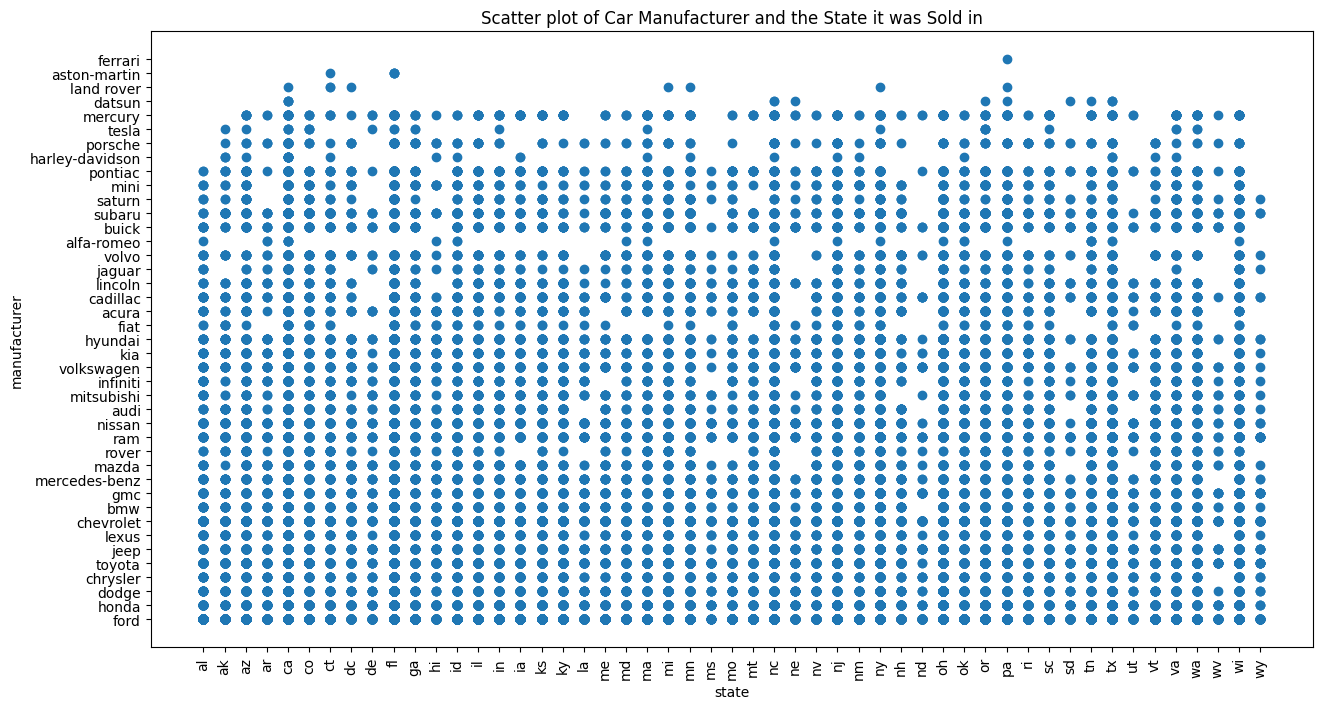

In [178]:
# Does location/state have an impact on which cars are sold?
plt.figure(figsize=(15, 8))
plt.scatter(x=df['state'], y=df['manufacturer'])
plt.xlabel('state')
plt.ylabel('manufacturer')
plt.title('Scatter plot of Car Manufacturer and the State it was Sold in')
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='size', ylabel='price'>

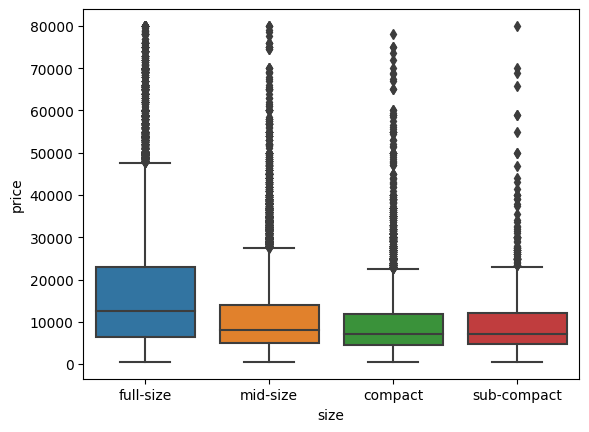

In [179]:
# How does size impact the average sale price?
sns.boxplot(x='size', y='price', data=df)

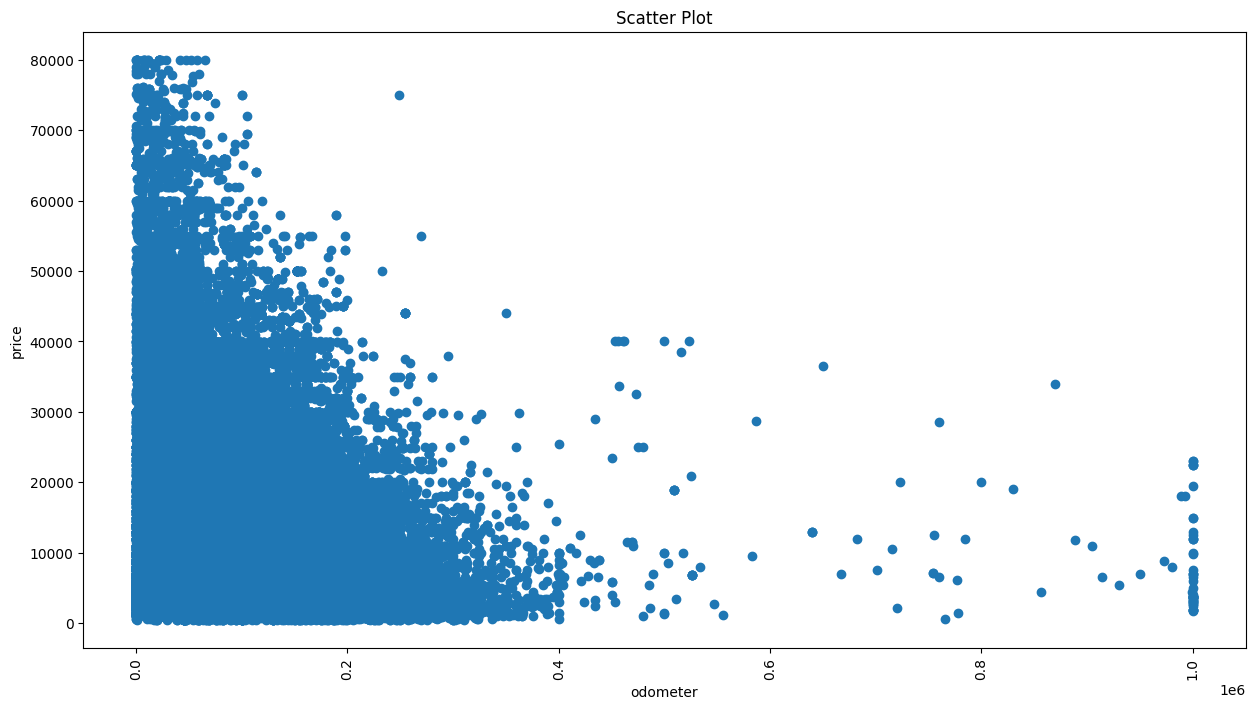

In [180]:
# How does the odomoeter value correlate to price?
odometer_x = df[df['odometer'] < 1000000]
price_y = odometer_x['price']


plt.figure(figsize=(15, 8))
plt.scatter(x=odometer_x['odometer'], y=price_y)
plt.xlabel('odometer')
plt.ylabel('price')
plt.title('Scatter Plot')
plt.xticks(rotation=90)
plt.show()

# Data Preparation

In [181]:
# Let's drop cars with a title_status of parts_only and salvage because they're unlikely to be
# sold on a used car lot
# Let's also drop any rows with salvage as the condition
df = df[df['title_status'] != 'salvage']
df = df[df['title_status'] != 'parts only']
df = df[df['condition'] != 'salvage']


# Let's ordinally incode data with a clear hierarchy
condition_order = ['fair', 'good', 'excellent', 'like new', 'new']
df['condition'], condition_map = pd.factorize(df['condition'], condition_order)

size_order = ['sub-compact','compact', 'mid-size','full-size']
df['size'], size_map = pd.factorize(df['title_status'], size_order)

title_status_order = ['missing', 'lien', 'rebuilt', 'clean']
df['title_status'], title_status_map = pd.factorize(df['title_status'], title_status_order)



In [182]:
# Convert year to years old to make intepretting easier
df['years_old'] = 2023 - df['year']
df.drop(columns=['year'], inplace=True)

In [183]:
# create a new feature to represent miles driven per year
df['miles_per_year'] = df['odometer'] / df['years_old']

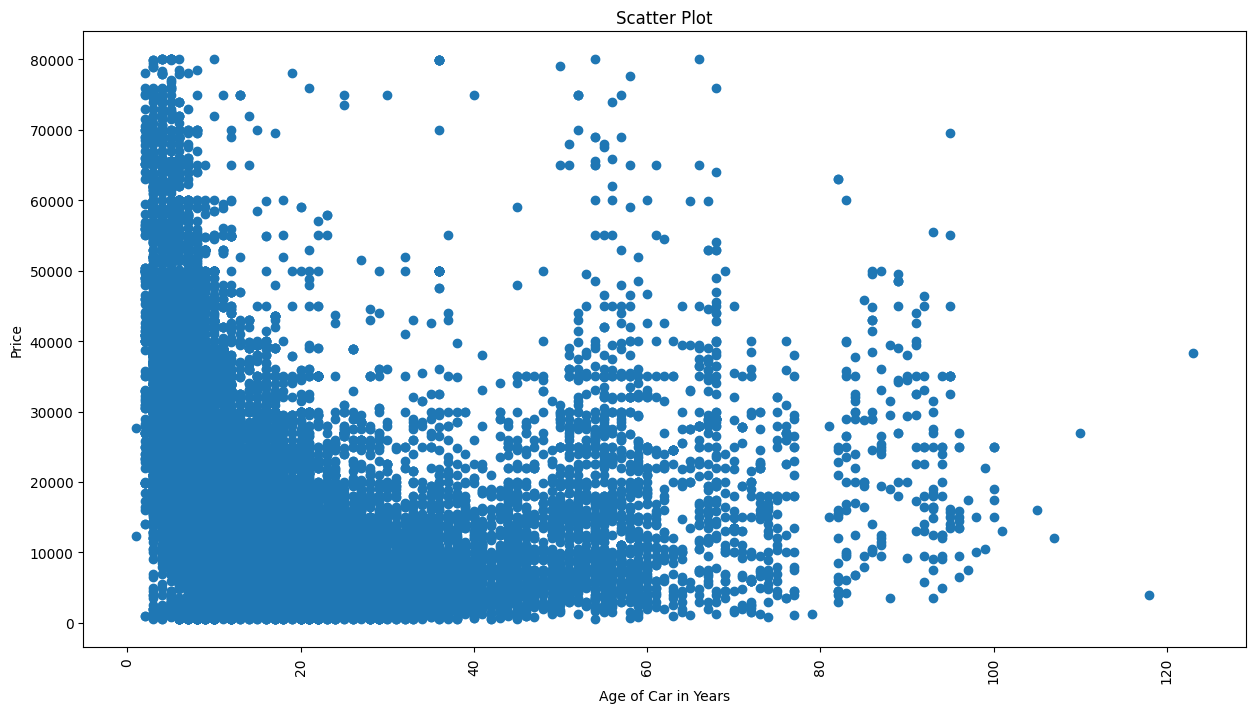

In [184]:
# How does the age of the car correlate to price?
plt.figure(figsize=(15, 8))
plt.scatter(x=df['years_old'], y=df['price'])
plt.xlabel('Age of Car in Years')
plt.ylabel('Price')
plt.title('Scatter Plot')
plt.xticks(rotation=90)
plt.show()

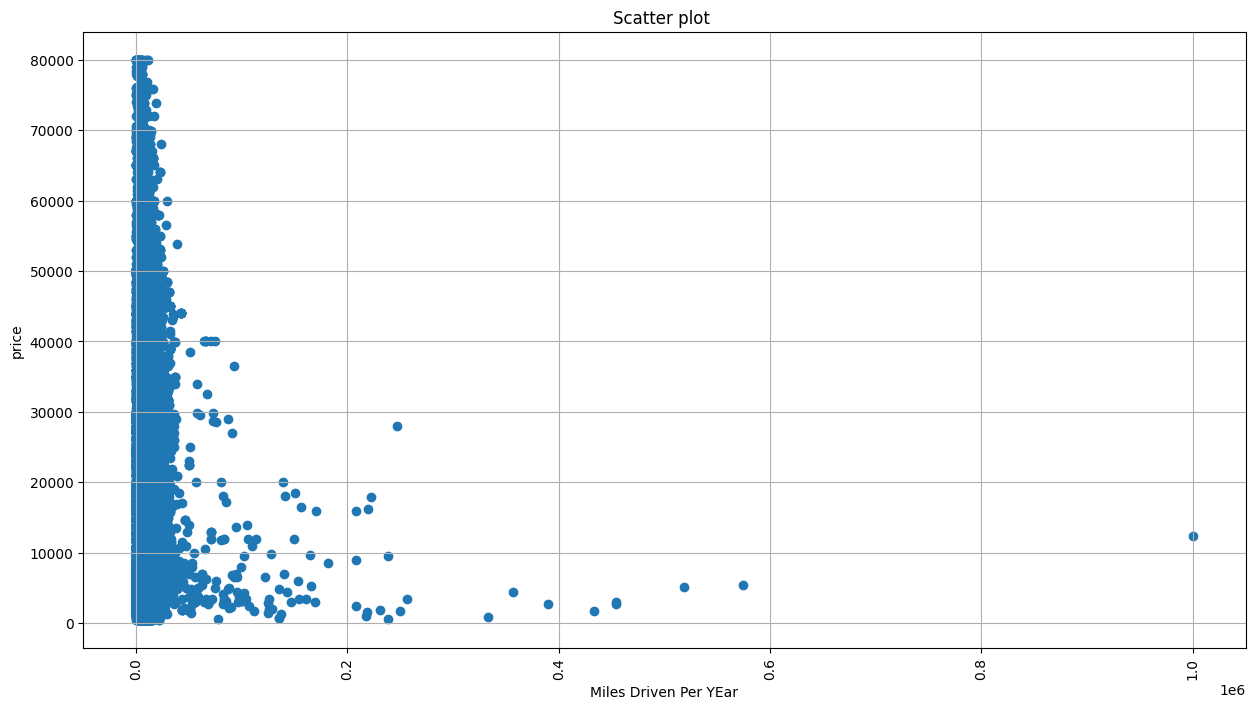

In [185]:
# How does the number of miles driven per year correlate to price?
plt.figure(figsize=(15, 8))
plt.scatter(x=df['miles_per_year'], y=df['price'])
plt.xlabel('Miles Driven Per YEar')
plt.ylabel('price')
plt.title('Scatter plot ')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [134]:
# let's also log transform the odometer and our new miles_per_year to help with outliers
small_constant = 1e-10
df['miles_per_year'] = np.log(df['miles_per_year']+ small_constant)
df['odometer'] = np.log(df['odometer']+ small_constant)

In [135]:
# What's the cardinality of the categorical features?
for column in df.columns:
  print(column, ' : ', df[column].nunique())

price  :  4042
manufacturer  :  41
condition  :  5
cylinders  :  8
fuel  :  5
odometer  :  26410
title_status  :  4
transmission  :  3
drive  :  3
size  :  4
type  :  13
paint_color  :  12
state  :  51
years_old  :  104
miles_per_year  :  33008


In [186]:
# Split our data into X and y for training
y = df['price']
X = df.drop(columns=['price'])

In [187]:
# We'll need to one-hot encode any remaining non-numerical data
columns_to_encode = ['manufacturer', 'cylinders',
                     'fuel', 'transmission', 'drive',
                     'size', 'type', 'paint_color', 'state']

transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False), columns_to_encode)
    ],
    remainder='passthrough'  # This means unaffected columns are left as they are
)

# Apply the transformation
X_encoded = transformer.fit_transform(X)

# Turn our one-hot encoded data back into a dataframe
X_encoded_df = pd.DataFrame(X_encoded, columns=transformer.get_feature_names_out(), index=X.index)

print(f'Total Number of Data Points is : {len(X_encoded_df)}')

Total Number of Data Points is : 73778


In [188]:
# split the data into our train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y, test_size=0.2, random_state=42)

# given how right skewed the data is, let's scale it to assist with our Ridge model performance
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Modeling


In [189]:
# create a baseline to compare our model performance to
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)

print(f'The MSE baseline for training is : {mse_baseline_train}')
print(f'The MSE baseline for test is : {mse_baseline_test}')

The MSE baseline for training is : 0.7316313593444461
The MSE baseline for test is : 0.7236695779374938


In [190]:
# Create a column transformer to scale the numerical columns with outsized values
cols_to_scale = ['remainder__odometer', 'remainder__years_old', 'remainder_miles_per_year']

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

# Create our Ridge Regression Model
ridge_param_dict = {'ridge__alpha' : np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('preprocessor', StandardScaler()),
                       ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid = ridge_param_dict)
ridge_grid.fit(X_train, y_train)
best_ridge_model = ridge_grid.best_estimator_
train_preds = best_ridge_model.predict(X_train)
test_preds = best_ridge_model.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, train_preds)
ridge_test_mse = mean_squared_error(y_test, test_preds)

# Train/Test MSE and Alpha for our selected Ridge Model
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')
best_alpha = ridge_grid.best_params_['ridge__alpha']
best_alpha
print(f"Best alpha: {best_alpha}")

Train MSE: 0.4354565983858362
Test MSE: 0.43143860844522974
Best alpha: 719.6856730011522


# Model Evaluation

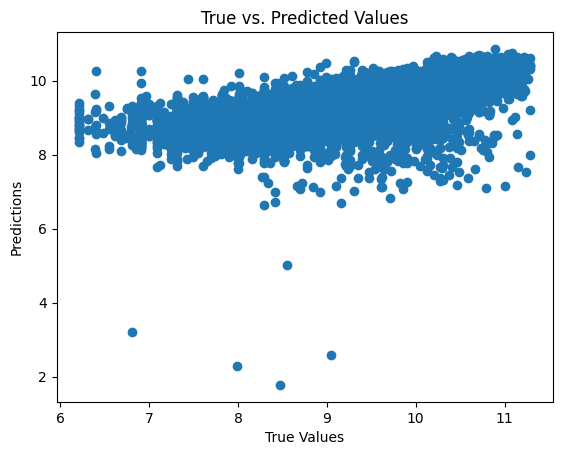

In [191]:
# How do our predicted values compaire to the true test values?
plt.scatter(y_test, test_preds)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs. Predicted Values")
plt.show()

In [192]:
# Pair coefficients with feature names to investigate their impact
coefficients = best_ridge_model['ridge'].coef_
feature_names = X_encoded_df.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Which features have the most negative impact on sale price?
coef_df.sort_values(by='Coefficient').head(20)

,Feature,Coefficient
143,remainder__years_old,-0.279064
141,remainder__odometer,-0.125532
58,onehot__drive_fwd,-0.110355
73,onehot__type_sedan,-0.083037
51,onehot__fuel_gas,-0.060264
140,remainder__condition,-0.043741
124,onehot__state_oh,-0.042803
64,onehot__type_SUV,-0.038650
68,onehot__type_hatchback,-0.037865
35,onehot__manufacturer_saturn,-0.034543


In [193]:
# Which features have the most positive impact on sale price?
coef_df.sort_values(by='Coefficient').tail(20)

,Feature,Coefficient
72,onehot__type_pickup,0.020613
135,onehot__state_vt,0.021397
93,onehot__state_ca,0.023306
131,onehot__state_tn,0.023684
38,onehot__manufacturer_toyota,0.024886
100,onehot__state_hi,0.026150
41,onehot__cylinders_10 cylinders,0.026534
75,onehot__type_van,0.026875
77,onehot__paint_color_black,0.028333
83,onehot__paint_color_orange,0.028446


In [194]:
# convert predictions back to original scale
y_test = np.expm1(y_test)
test_preds = np.expm1(test_preds)

## look at columns with the worst predicted results
residuals = y_test - test_preds
squared_errors = residuals ** 2

X_test['prediction'] = test_preds
#X_test.drop(columns = ['price'], inplace=True)
X_test['price'] = y_test
X_test['mse'] = (X_test['price'] - X_test['prediction'])**2
# Calculate the absolute difference between target and prediction
X_test['diff'] = abs(X_test['price'] - X_test['prediction'])

In [207]:
# What percentage of our predications are within 5K of the actual sale price?
within_5k = X_test[X_test['diff'] <= 5000].shape[0] / X_test.shape[0] * 100

print(f"{within_5k:.2f}% of predictions are within $5,000 of the actual price.")

31.50% of predictions are within $5,000 of the actual price.
